# NBA Exploratory Data Analysis

<img src="resources/nba-logo.png" style="width: 300px;"/>

## Methodology

In an attempt to gain a deeper understanding of data analysis methods, we will perform seven forms of analysis on data from the National Basketball Association (NBA) that was collected over many seasons of play. These forms of analysis are:

1. Observational Statistics
2. Visualization
3. Linear System of Equations
4. Interpolation
5. Least Squares
6. Fourier Analysis
7. Principal Components

//TO-DO: Needs teammate responsibilities

This notebook supplies our Python 3.6.3 implementation of the aforementioned analysis techniques alongside richer documentation, including Markdown, figures, and the produced output. When executed, this notebook uses an IPython 6.1.0 kernel to execute Python code.

## Data Collection

![](resources/kaggle_logo.png)

We obtained our data from the self-proclaimed "home of data science and machine learning", [Kaggle](https://www.kaggle.com/). It is a good resource for downloading data sets, and it also hosts competitions in data analysis.

The raw data is in two sets: player information and season statistics. The sets include 3,922 and 24,691 observations with 7 and 53 attributes, respectively.

## Setup

To start, we will import the following resources:

- Data manipulation from `numpy` and `pandas`
- Plotting capability from `matplotlib`

We also need to tell `matplotlib` to output inline in our notebook.

Then, we will load the player information and season statistics that we are looking to analyze.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [2]:
# Load player information and season statistics
player_info = pd.read_csv('resources/player-info.csv')
season_stats = pd.read_csv('resources/season-stats.csv')

We need to verify that we got the data.

In [3]:
print("player_info shape:", player_info.shape)
print("season_stats shape:", season_stats.shape)

player_info shape: (3922, 8)
season_stats shape: (24691, 53)


In [4]:
player_info.head()

,Unnamed: 0,name,height,weight,college,birth_year,birth_city,birth_state
0,0,Curly Armstrong,180.0,77.0,Indiana University,1918.0,NaN,NaN
1,1,Cliff Barker,188.0,83.0,University of Kentucky,1921.0,Yorktown,Indiana
2,2,Leo Barnhorst,193.0,86.0,University of Notre Dame,1924.0,NaN,NaN
3,3,Ed Bartels,196.0,88.0,North Carolina State University,1925.0,NaN,NaN
4,4,Ralph Beard,178.0,79.0,University of Kentucky,1927.0,Hardinsburg,Kentucky


In [5]:
season_stats.head()

,id,year,name,pos,age,tm,g,gs,mp,per,...,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts
0,0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,...,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,...,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0
2,2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,...,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0
3,3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,...,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0
4,4,1950.0,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,...,0.548,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0


It looks like some cleaning needs to be done before we can begin analyzing.

## Data Cleaning

Cleaning the data will involve:

1. Re-labeling the CSV files
2. Removing the "Unnamed: 0" column from player info
3. Re-indexing the player info
4. Joining the data sets
5. Trim observations taken under antiquated rules
6. Trimming statistics that we are uninterested in
7. Drop null observations
8. Parallelize player names

### 1. Re-label the CSV files

We re-labeled the first column of `season-stats.csv` to `id`, to reflect its purpose. We do not need to re-label the first, unnamed column of `player-info.csv`, as the players' names serve as unique identifiers themselves; we will be removing the unnamed column promptly.

### 2. Remove the "Unnamed: 0" column

In [6]:
# Drop the unnamed first column.
player_info.drop('Unnamed: 0', axis=1, inplace=True)

### 3. Re-index player info

In [7]:
# Set the dataframe index to player names.
player_info.set_index('name', inplace=True)

### 4. Join the sets

In [8]:
# Join player info and season stats on the players' names.
complete_stats = season_stats.join(player_info, on="name")
complete_stats.head(3)

,id,year,name,pos,age,tm,g,gs,mp,per,...,blk,tov,pf,pts,height,weight,college,birth_year,birth_city,birth_state
0,0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,...,NaN,NaN,217.0,458.0,180.0,77.0,Indiana University,1918.0,NaN,NaN
1,1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,...,NaN,NaN,99.0,279.0,188.0,83.0,University of Kentucky,1921.0,Yorktown,Indiana
2,2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,...,NaN,NaN,192.0,438.0,193.0,86.0,University of Notre Dame,1924.0,NaN,NaN


### 5. Trim observations taken under antiquated rules

We will trim all observations before 1990 to eliminate the difference in statistics caused by rule changes; the game used to allow for more possessions of the ball, thereby allowing for more points, rebounds, assists, etc.

Admittedly, 1990 has been chosen at our discretion; there have been many small rule changes, but this date encompasses most of the major ones.

In [9]:
trimmed_stats = complete_stats.loc[complete_stats.year >= 1990]
trimmed_stats.head()

,id,year,name,pos,age,tm,g,gs,mp,per,...,blk,tov,pf,pts,height,weight,college,birth_year,birth_city,birth_state
9547,9547,1990.0,Mark Acres,C,27.0,ORL,80.0,50.0,1691.0,8.3,...,25.0,70.0,248.0,362.0,211.0,99.0,Oral Roberts University,1962.0,Inglewood,California
9548,9548,1990.0,Michael Adams,PG,27.0,DEN,79.0,74.0,2690.0,15.4,...,3.0,141.0,133.0,1221.0,178.0,73.0,Boston College,1963.0,Hartford,Connecticut
9549,9549,1990.0,Mark Aguirre,SF,30.0,DET,78.0,40.0,2005.0,15.8,...,19.0,121.0,201.0,1099.0,198.0,105.0,DePaul University,1959.0,Chicago,Illinois
9550,9550,1990.0,Danny Ainge,PG,30.0,SAC,75.0,68.0,2727.0,16.1,...,18.0,185.0,238.0,1342.0,193.0,79.0,Brigham Young University,1959.0,Eugene,Oregon
9551,9551,1990.0,Mark Alarie,PF,26.0,WSB,82.0,10.0,1893.0,14.1,...,39.0,101.0,219.0,860.0,203.0,98.0,Duke University,1963.0,Phoenix,Arizona


### 6. Trim uninteresting statistics

Instead of trimming the uninteresting statistics, we opt to *select* the ones we are interested in. We want less than half of the total attributes, so this way saves us some work.

There will be some additional trims made because some attributes can be derived from others, such as the percentages of shots made being derived from shots made and shots attempted.

In [10]:
trimmed_stats = trimmed_stats[[
    'id', 
    'year',
    'name',
    'age',
    'g',
    'mp',
    'per',
    'ws',
    'fg',
    'fga',
    '3p',
    '3pa',
    '2p',
    '2pa',
    'ft',
    'fta',
    'orb',
    'drb',
    'ast',
    'stl',
    'blk',
    'tov',
    'pf',
    'pts',
    'height',
    'weight'
]]
trimmed_stats.head()

,id,year,name,age,g,mp,per,ws,fg,fga,...,orb,drb,ast,stl,blk,tov,pf,pts,height,weight
9547,9547,1990.0,Mark Acres,27.0,80.0,1691.0,8.3,1.6,138.0,285.0,...,154.0,277.0,67.0,36.0,25.0,70.0,248.0,362.0,211.0,99.0
9548,9548,1990.0,Michael Adams,27.0,79.0,2690.0,15.4,6.9,398.0,989.0,...,49.0,176.0,495.0,121.0,3.0,141.0,133.0,1221.0,178.0,73.0
9549,9549,1990.0,Mark Aguirre,30.0,78.0,2005.0,15.8,5.7,438.0,898.0,...,117.0,188.0,145.0,34.0,19.0,121.0,201.0,1099.0,198.0,105.0
9550,9550,1990.0,Danny Ainge,30.0,75.0,2727.0,16.1,4.8,506.0,1154.0,...,69.0,257.0,453.0,113.0,18.0,185.0,238.0,1342.0,193.0,79.0
9551,9551,1990.0,Mark Alarie,26.0,82.0,1893.0,14.1,3.1,371.0,785.0,...,151.0,223.0,142.0,60.0,39.0,101.0,219.0,860.0,203.0,98.0


### 7. Drop null observations

In [11]:
# Get a count for null observations
trimmed_stats.isnull().sum()

id        0
year      0
name      0
age       0
g         0
mp        0
per       5
ws        0
fg        0
fga       0
3p        0
3pa       0
2p        0
2pa       0
ft        0
fta       0
orb       0
drb       0
ast       0
stl       0
blk       0
tov       0
pf        0
pts       0
height    0
weight    0
dtype: int64

In [12]:
trimmed_stats = trimmed_stats.dropna(how='any')

In [13]:
trimmed_stats.isnull().sum()

id        0
year      0
name      0
age       0
g         0
mp        0
per       0
ws        0
fg        0
fga       0
3p        0
3pa       0
2p        0
2pa       0
ft        0
fta       0
orb       0
drb       0
ast       0
stl       0
blk       0
tov       0
pf        0
pts       0
height    0
weight    0
dtype: int64

### 8. Parallelize player names

We want to move the player names into their own parallel DataFrame so that their qualitative nature does not interfere with our analyses.

In [28]:
# To avoid refactoring and still be able to access names more easily...
stats_with_names = trimmed_stats.copy(deep=True)

player_names = trimmed_stats[['id', 'name']]
trimmed_stats.drop(axis=1, labels=['name'], inplace=True)
trimmed_stats.head()

KeyError: "['name'] not in index"

## Analysis

As a reminder, the seven forms of analysis we will perform are:

1. Observational Statistics
2. Visualization
3. Linear System of Equations
4. Interpolation
5. Least Squares
6. Fourier Analysis
7. Principal Components

### 1. Observational Statistics


Here we will find out some interesting information about our players
#### Height


In [15]:
max_height_ids = trimmed_stats[trimmed_stats.height == trimmed_stats.height.max()]["id"]
names = player_names[player_names.id.isin(max_height_ids)]
names = names.drop_duplicates(keep='first', subset='name')
names = trimmed_stats.merge(names, on='id')[['name', 'height']]
print("These are the tallest players since 1990:")
print(names)
print()

min_height_ids = trimmed_stats[trimmed_stats.height == trimmed_stats.height.min()]["id"]
names = player_names[player_names.id.isin(min_height_ids)]
names = names.drop_duplicates(keep='first', subset='name')
names = trimmed_stats.merge(names, on='id')[['name', 'height']]
print("These are the shortest players since 1990:")
print(names)
print()

print("The average height of nba players since 1990 is: ", trimmed_stats['height'].mean(), " cm" )

These are the tallest players since 1990:
               name  height
0        Manute Bol   231.0
1  Gheorghe Muresan   231.0
()
These are the shortest players since 1990:
            name  height
0  Muggsy Bogues   160.0
()
('The average height of nba players since 1990 is: ', 200.28593170989942, ' cm')


#### Age

In [16]:
max_age_ids = trimmed_stats[trimmed_stats.age == trimmed_stats.age.max()]["id"]
names = player_names[player_names.id.isin(max_age_ids)]
names = names.drop_duplicates(keep='first', subset='name')
names = trimmed_stats.merge(names, on='id')[['name', 'age']]
print("These are the oldest players since 1990:")
print(names)
print()

min_age_ids = trimmed_stats[trimmed_stats.age == trimmed_stats.age.min()]["id"]
names = player_names[player_names.id.isin(min_age_ids)]
names = names.drop_duplicates(keep='first', subset='name')
names = trimmed_stats.merge(names, on='id')[['name', 'age']]
print("These are the youngest players since 1990:")
print(names)
print()

print("The average age of nba players since 1990 is: ", trimmed_stats['age'].mean(), " years old" )

These are the oldest players since 1990:
           name   age
0  Kevin Willis  44.0
()
These are the youngest players since 1990:
                name   age
0        Kobe Bryant  18.0
1    Jermaine O'Neal  18.0
2      Tracy McGrady  18.0
3      Al Harrington  18.0
4       Bruno Sundov  18.0
5       Maciej Lampe  18.0
6      Darko Milicic  18.0
7    Andris Biedrins  18.0
8       Andrew Bynum  18.0
9       Amir Johnson  18.0
10  Yaroslav Korolev  18.0
11        C.J. Miles  18.0
()
('The average age of nba players since 1990 is: ', 26.981008470089996, ' years old')


#### Points

In [17]:
max_points_ids = trimmed_stats[trimmed_stats.pts == trimmed_stats.pts.max()]["id"]
names = player_names[player_names.id.isin(max_points_ids)]
names = names.drop_duplicates(keep='first', subset='name')
names = trimmed_stats.merge(names, on='id')[['name', 'pts']]
print("The most points scored in an NBA season since 1990 was: ")
print(names)
print()

min_points_ids = trimmed_stats[trimmed_stats.pts == trimmed_stats.pts.min()]["id"]
names = player_names[player_names.id.isin(min_points_ids)]
names = names.drop_duplicates(keep='first', subset='name')
names = trimmed_stats.merge(names, on='id')[['name', 'pts']]
print("There were ", names.size / 2, " players who scored 0 points in a season since 1990.")
print()

print("The average number of points in a season since 1990 is: ", trimmed_stats['pts'].mean(), " points" )

The most points scored in an NBA season since 1990 was: 
          name     pts
0  Kobe Bryant  2832.0
()
('There were ', 181, ' players who scored 0 points in a season since 1990.')
()
('The average number of points in a season since 1990 is: ', 463.21188459502383, ' points')


#### Blocks

In [18]:
max_block_ids = trimmed_stats[trimmed_stats.blk == trimmed_stats.blk.max()]["id"]
names = player_names[player_names.id.isin(max_block_ids)]
names = names.drop_duplicates(keep='first', subset='name')
names = trimmed_stats.merge(names, on='id')[['name', 'blk']]
print("The player with the most blocks since 1990 is:")
print(names)
print()

min_block_ids = trimmed_stats[trimmed_stats.blk == trimmed_stats.blk.min()]["id"]
names = player_names[player_names.id.isin(min_block_ids)]
names = names.drop_duplicates(keep='first', subset='name')
names = trimmed_stats.merge(names, on='id')[['name', 'blk']]
print("There were ", names.size / 2, " players who recorded 0 blocks in a season since 1990.")


print()

print("The average height of nba players since 1990 is: ", trimmed_stats['blk'].mean(), " blocks" )

The player with the most blocks since 1990 is:
               name    blk
0  Hakeem Olajuwon*  376.0
()
('There were ', 1010, ' players who recorded 0 blocks in a season since 1990.')
()
('The average height of nba players since 1990 is: ', 23.1173239809423, ' blocks')


### 2. Visualization

Here we will display some plesant graphs 

#### Height distribution

[]

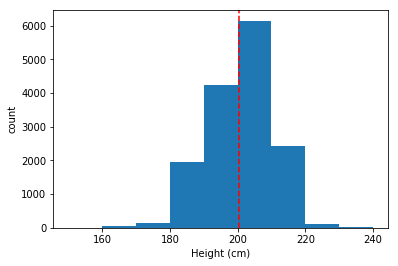

In [21]:
bins = range(150, 250, 10)
plt.hist(trimmed_stats["height"], bins, histtype="bar")
plt.xlabel("Height (cm)")
plt.ylabel("count")
plt.axvline(trimmed_stats['height'].mean(), color='r', linestyle='dashed')
plt.plot()

**Observation:** The majority of players fell into a height range of 190 cm to 210 cm (6'2" to 6'10"), and the average player is roughly 200 cm tall. 

#### Age distribution

[]

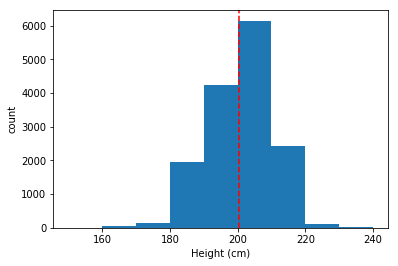

In [25]:
bins = range(150, 250, 10)
plt.hist(trimmed_stats["height"], bins, histtype="bar")
plt.xlabel("Height (cm)")
plt.ylabel("count")
plt.axvline(trimmed_stats['height'].mean(), color='r', linestyle='dashed')
plt.plot()

**Observation:** Most players fell between an age range of 22 to 30 years old, and the average player is 27 years old. This speaks to the longevity of careers in the NBA; most people do not end up playing for more than five to eight years. 

#### Weight distribution

[]

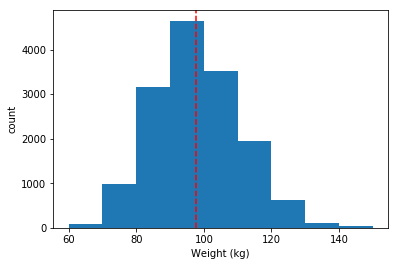

In [26]:
bins = range(60, 160, 10)
plt.hist(trimmed_stats["weight"], bins, histtype="bar")
plt.xlabel("Weight (kg)")
plt.ylabel("count")
plt.axvline(trimmed_stats['weight'].mean(), color='r', linestyle='dashed')
plt.plot()

**Observation:** Most of our players weigh between 80 and 120 kg (175 to 265 lbs) and the average weight was about 95 kg. 

#### Blocks

[]

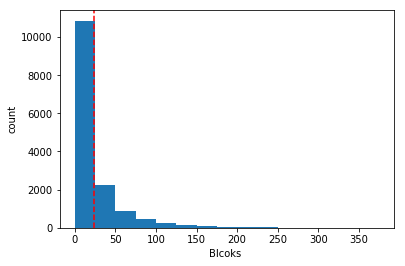

In [27]:
bins = range(0, 400, 25)
plt.hist(trimmed_stats["blk"], bins, histtype="bar")
plt.xlabel("Blcoks ")
plt.ylabel("count")
plt.axvline(trimmed_stats['blk'].mean(), color='r', linestyle='dashed')
plt.plot()

**Observation:** Almost all of the players had between 0 and 25 blocks on average per season, and the average player had 23 blocks per season. I found these numbers to be surprising; the average player gets roughly .28 blocks per game, or a block every four games. 

### 3. Linear System of Equations

### 4. Interpolation

### 5. Least Squares

We will be considering four pairs of statistics for finding fits in the least-squares sense:

Independent | Dependent
:---: | :---:
Age | Points
Age | Minutes Played
Height | Total Rebounds
Weight | Steals

#### Age vs. Points

Slope: -0.952739707235


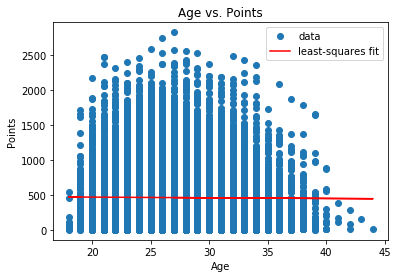

In [15]:
x = trimmed_stats.age
y = trimmed_stats.pts

A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, y)[0]
print("Slope:", m)

plt.plot(x, y, 'o', label="data")
plt.plot(x, m * x + c, 'r', label="least-squares fit")
plt.title("Age vs. Points")
plt.xlabel("Age")
plt.ylabel("Points")
plt.legend()
plt.show()

From the slightly negative slope, we can see that age only has a slight, negative correlation with points. This is interesting, and may be explained by younger players playing less minutes as they start out in the league.

#### Age vs. Minutes

Slope: 6.76560250141


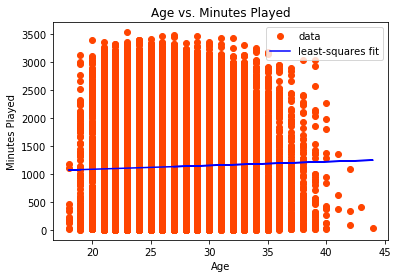

In [16]:
x = trimmed_stats.age
y = trimmed_stats.mp

A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, y)[0]
print("Slope:", m)

plt.plot(x, y, 'o', label="data", color="#ff4400")
plt.plot(x, m * x + c, 'r', label="least-squares fit", color="#0000ff")
plt.title("Age vs. Minutes Played")
plt.xlabel("Age")
plt.ylabel("Minutes Played")
plt.legend()
plt.show()

There is a clear positive trend present; as players age in the league, they are granted more play time. This helps account for the lack of a difference in points that one might expect between older and younger players.

#### Height vs. Total Rebounds

Slope: 5.77935707866


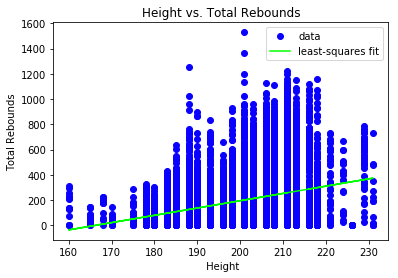

In [17]:
x = trimmed_stats.height
y = trimmed_stats.orb + trimmed_stats.drb

A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, y)[0]
print("Slope:", m)

plt.plot(x, y, 'o', label="data", color="#0a00ff")
plt.plot(x, m * x + c, 'r', label="least-squares fit", color="#00ff00")
plt.title("Height vs. Total Rebounds")
plt.xlabel(" Height")
plt.ylabel("Total Rebounds")
plt.legend()
plt.show()

We can see that there is a positive correlation between height and total rebounds, as should be expected. It is interesting to note that this association is actually weaker than the one between age and minutes played.

#### Weight vs. Steals

Slope: -0.503560604608


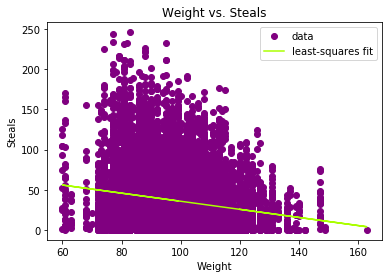

In [18]:
x = trimmed_stats.weight
y = trimmed_stats.stl

A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, y)[0]
print("Slope:", m)

plt.plot(x, y, 'o', label="data", color="purple")
plt.plot(x, m * x + c, 'r', label="least-squares fit", color="#aaff00")
plt.title("Weight vs. Steals")
plt.xlabel("Weight")
plt.ylabel("Steals")
plt.legend()
plt.show()

As one would expect, there is a negative trend; lighter players can move around and steal the ball more easily.

### 6. Fourier Analysis

### 7. Principal Components

## Reflection